# <span style="color:green"> Run on python 3.6</span>

# Explanations:

Авторы используют multi output GPR, настраивая гиперпараметры $\sigma_{cov}$ и $\sigma_{err}$ (можно однозначно их выразить через гиперпараметры из того же sklearn: $l$ и $\sigma$)

GPR - непараметрический метод, суть в том, что мы делаем предположение о виде матрицы корреляции признаков для известных данных. (но можно добавлять некоторые параметры в ядро и их градиентными методами "обучать", потому что все что мы делаем - перемножаем матрицы и используем элементарные функции)

---

Моделирование в хотя бы немного более сложном случае буду писать на Julia

---

Гиперпараметры:

1)k: Количество элементов в массивах r_cut и p для каждого атома

2)$r_{cut}(i)_j$, i=1..k, j=1..N: векторы r_cut для j атома тоже параметр

3)$p_(i)_j$, i=1..k, j=1..N: векторы p для j атома тоже параметр

4)N_neighbours for summation for IVs

В GPyTorch есть имплементация многоразмерного регрессора: https://docs.gpytorch.ai/en/stable/examples/03_Multitask_Exact_GPs/index.html#multi-output-vector-valued-functions

---

- **Зачем предсказывать именно K-мерный вектор силы:** 
    - В системе из 3+ частиц гантелька из двух частиц может вращаться, тогда матрица признаков не изменяется у частиц из этой гантельки, а 3Д сила изменяется, но любое отображение может выдавать только 1 значение для 1 аргумента, то есть мы банально сможем выдавать только одну 3Д силу в таком случае,
    однако если мы предсказываем К-мерный вектор, то он все равно будет только 1 выдаваться для частицы из этой вращающейся гантельки, но матрица А при этом будет разной в каждом состоянии и сможем получать разные 3Д векторы силы 

---

Пока что все размерности предполагаются в системе LJ, потому что пока пытаюсь это зафитить

В данный момент при вычислении псевдообратной матрицы очень большая ошибка получается

In [147]:
import random
import os
import time

from numba import jit, njit, vectorize
import numpy as np
import scipy
from numpy.linalg import norm as norm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [148]:
def set_seed(seed = 42):
    '''
    
    Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.

    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

---

# Hyperparameters:

In [149]:
class CFG:
    '''

    All hyperparameters are here

    '''

    N = 2     # число атомов
    K = 10     # можно называть это разрешением...чем число больше, тем больше размеры матрицы для атомов, фактически это число элементов в наборах p и r_cut

    L = L = 2 * N ** (1 / 3) # размер одной клетки при моделировании

    r_cut = np.random.uniform(low=5, high=10, size=K).copy()       # тут все совсем зависит от модели силы, которую используем...
    p = np.random.uniform(low=1, high=3, size=K).copy()     # В статье от 1 до 3 говорят, что норм

    N_neig= N - 1 if N != 2 else 1

    # train_bs = 8
    # val_bs = 16
    batch_size = 256

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    f_threshold = 10    # Если сила по какой-то координате превышает это значение, то строчка исключается, совсем маленьких по модулю сил быть не должно, если что при генерации просто r_cut поменьше надо делать
    coord_threshold = 2 * L     # Если вдруг очень большие расстояния, то надо выкидывать
    #
    output_size = K     # Размерность аутпута модели

---

Имеется два .csv файла:

1)
| Id(time) | 1_x | 1_y | 1_z | ... | N_z |
|------|-----|-----|-----|-----|-----|
|      |     |     |     |     |     |
|      |     |     |     |     |     |
2)
| Id(time) | f_1_x | f_1_y | f_1_z | ... | f_N_z |
|------|-----|-----|-----|-----|-----|
|      |     |     |     |     |     |
|      |     |     |     |     |     |

Одна строчка отсюда превращается в N матриц (на каждый атом) с N векторами сил

В идеале сделать БДху из двух сущностей: сила и координата, где полями будут их проекции

In [150]:
def create_df_with_coords(coords_file_path = None, forces_file_path = None):
    '''
    just makes df from .csvs with coords and forces
    '''
    coords = pd.read_csv(coords_file_path)

    forces = pd.read_csv(forces_file_path)

    if CFG.N != int(coords.columns[-1][:-1]) + 1:
        raise Exception('Constant N is not equal to amount of particles in .csv')

    return pd.merge(left=coords, right=forces, on='t').drop('t', axis='columns')

12 индекс - 1 отн 2

$$
\vec{r_1} = \vec{r_2} + \vec{r}_{12}
$$

$$
\vec{r}_{12} = \vec{r_1} - \vec{r}_{2}
$$

In [151]:
def _get_relative_positions(row, atom_number):
    '''
    This function processes one row of csv into something that we can work with

    Returns np.array matrix that consists of relative positions vectors for passed atom_number to every other atom
    and then we can chose only closest N_neighbours in the next functions
    
    row: df.iloc[row] - typeof(row): pd.Series
    
    returns: Rel_matrix, f_vec
    '''

    s_coord = pd.Series(dtype=float)
    other_atom_numbers = [i for i in range(CFG.N) if i != atom_number]

    for other_numb in other_atom_numbers:
        index = str(atom_number) + str(other_numb)
        for axis in ['x', 'y', 'z']:
            s_coord[index + axis] = row[str(atom_number) + axis] - row[str(other_numb) + axis]

    # we need force vector only for atom_number:
    force_vec = []
    for f_axis in ['f_x', 'f_y', 'f_z']:
        force_vec.append(row[str(atom_number) + f_axis])

    Rel_matrix = []
    cur_vector = []

    for (i, elem) in enumerate(s_coord.values):
        if i % 3 == 0 and i != 0:
            Rel_matrix.append(cur_vector)
            cur_vector = []

        cur_vector.append(elem)
    Rel_matrix.append(cur_vector)

    return np.array(Rel_matrix), np.array(force_vec)

In [152]:
from sklearn.preprocessing import normalize

In [153]:
@njit(fastmath=True)
def make_one_vec_transformed(vec, vec_norm, r_cut_i, p_i):
    '''
    vec: np.array - normalized vector
    norm: its norm
    r_cut_i: i-th component of
    '''
    return vec * np.exp(
        -np.power((vec_norm / r_cut_i), p_i)
        )

make_matrix_transformed = np.vectorize(make_one_vec_transformed)

def create_V_i(i, normalized_m, norms, r_cut=CFG.r_cut, p=CFG.p):
    '''
    normalized_m: matrix of relative distances, where rows - normalized vectors
    i: i-th component of r_cut and p, i in range 1..K (or in 0..K-1 in code)
    '''
    transf_vecs = make_matrix_transformed(normalized_m, norms[:, np.newaxis], r_cut[i], p[i])

    return np.sum(transf_vecs, axis=0)

# @njit(parallel=True)
def create_V(normalized_m, norms, K=CFG.K):
    '''
    creates V
    '''
    V = []
    for i in range(K):
        V.append(
            create_V_i(i, normalized_m, norms)
        )

    return np.stack(V)

In [154]:
# @njit(
#     # parallel=True,
#     # fastmath=True
#     )
def _calculate_matrix_for_atom(relative_distances, r_cut=CFG.r_cut, p=CFG.p, N_neig=CFG.N_neig, K=CFG.K):
    '''

    relative_distances: np.array matrix of relative distance vectors

    '''
    
    # Only closest N_neig are counting:
    indexlist = np.argsort(norm(relative_distances, axis=1))

    relative_distances = relative_distances[indexlist[len(relative_distances) - N_neig:]]

    norms = norm(relative_distances, axis=-1)

    normalized_rel_distances = relative_distances / norms[:, np.newaxis]

    V = create_V(normalized_rel_distances, norms)

    if np.inf in V / norm(V, axis=-1)[:, np.newaxis] or np.nan in V / norm(V, axis=-1)[:, np.newaxis]:
        print(f'V:\n {V}\n norms:\n {norm(V, axis=-1)[:, np.newaxis]}\n normed_V:\n {V / norm(V, axis=-1)[:, np.newaxis]}')
        print(f'ABOUT RELATIVE DISTANCES:\n rel_dists:\n {relative_distances}\n norms:\n{norms}\n normalized_rel_dists:\n {normalized_rel_distances}')

    A = V / norm(V, axis=-1)[:, np.newaxis]

    X = V @ A.T

    return X, A

In [155]:
def get_matrix_for_atom(row = None, atom_number = None, N_neig=CFG.N_neig):
    '''

    This function will create X matrix for passed atom with
    arrays of r_cut and p of length k

    It is a wrapper for _get_relative_positions and _calculate_matrix_for_atom, so I can speed up matrix calculations
    with numba for _calculate_matrix_for_atom

    atom_number: a number of atom that we are passing
    row: one row from df_with_coords, i.e. df.iloc[index_of_row]

    '''

    # creating row of relative coordinates for concrete atom:
    relative_distances, f_vec = _get_relative_positions(row=row, atom_number=atom_number)
    X, A = _calculate_matrix_for_atom(relative_distances=relative_distances, N_neig=N_neig)
    
    return X, f_vec, A

# %timeit get_matrix_for_atom(row=df.iloc[0], atom_number=1)

In [156]:
from tqdm import tqdm
import gc
import torchvision.transforms as transforms

**У нас будет train и val выборки, все-таки выборку, для который известен таргет принято называть validation, на которой мы качество оцениваем, а test это все-таки выборка, для который неизвестны таргеты**

In [157]:
def clean_df(df: pd.DataFrame, f_threshold = CFG.f_threshold, coord_threshold=CFG.coord_threshold):
    '''

    Убирает строчки с аномально большими силами из df

    '''

    indexes_for_deletion = set()

    for numb in range(CFG.N):
        for coord in ['f_x', 'f_y', 'f_z']:

            indexes_for_deletion = indexes_for_deletion.union(
                set(df[abs(df[str(numb) + coord]) > f_threshold].index)
            )

        for coord in ['x', 'y', 'z']:
            indexes_for_deletion = indexes_for_deletion.union(
                set(df[abs(df[str(numb) + coord]) > coord_threshold].index)
            )

    return df.drop(list(indexes_for_deletion))

In [158]:
@njit
def get_pinv(A):
    '''

    returns pseudoinverse matrix for input

    '''
    return np.linalg.inv(A.T @ A) @ A.T

def get_projections(vec_to_project, mat_of_directions):
    '''

    returns projection of vec_to_project on every vector from mat_of_directions

    '''
    return (mat_of_directions @ vec_to_project) / norm(mat_of_directions, axis=-1)

def create_tensor_dataset(
    coords_file_path = 'coords.csv', forces_file_path = 'forces.csv', step=1, transform=transforms.ToTensor(), length=None,
    f_threshold=CFG.f_threshold,
    coord_threshold=CFG.coord_threshold,
    ):
    '''

    Примитивная версия датасета, просто все будет хранить в одном списке...

    Эта функция - wrapper на все выше написанные функции, она по переданным путям к .csv
    возвращает тензор из матриц для каждого атома в каждой строчке и тензор из векторов сил

    ИНогда есть смысл делать побольше шаг между соседними строчками, поскольку если есть почти одинаковые матрицы, то
    это по-сути линейная зависимость и модель тогда надо сильнее регулизировать

    transform: преобразование к X части датасета, в основном для нормализации нужно, хотя о нормализации надо еще подумать и будет ли тогда наше МНК через матрицу A+ работать

    step: через сколько строчек шагать при чтении csv в датасет, чтобы уж совсем одинаковых не было

    Возвращает: list of (X, k_dim_f, A_pinv, F_3D)

    '''

    dataset = []

    df = create_df_with_coords(coords_file_path=coords_file_path, forces_file_path=forces_file_path)
    if length:
        df = df.loc[range(length)]

    # Сюда будет вставлена чистка df от больших сил
    df = clean_df(df, f_threshold=f_threshold, coord_threshold=coord_threshold)

    row_indexes = [i for i in range(0, len(df.index), step)]

    for atom_number in range(CFG.N):
        for index in tqdm(row_indexes, desc=f'Progress for atom {atom_number}'):
            row = df.iloc[index]
            x, F_3D, A = get_matrix_for_atom(row=row, atom_number=atom_number)

            if transform:
                x = transform(x)
            else:
                x = transforms.ToTensor()(x)
            x = x.to(torch.float)

            k_dim_f = get_projections(vec_to_project=F_3D, mat_of_directions=A)

            dataset.append(
                (x, torch.tensor(k_dim_f, dtype=torch.float), torch.tensor(get_pinv(A), dtype=torch.float), torch.tensor(F_3D, dtype=torch.float))
                )
            
            # В дальнейшем для других моделей может иметь смысл хранить и возвращать тут (x, f, A), где A - соответствующая матрица для X

    gc.collect()

    return dataset

In [159]:
# Когда только начинаю работать с датасетом надо один раз на трейне посчитать std и mean, чтобы нормализовать можно было

mean = 1.1201671361923218
std = 0.3449265956878662

In [160]:
# все-таки у нас тут не картинки будут, поэтому я попробую сначала даже без нормализации, нормализовать надо 1 канал, если в терминах картинки рассуждать

transform = transforms.Compose([                                    
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),                    
])

In [161]:
dataset = create_tensor_dataset(coords_file_path='coords2.csv', forces_file_path='forces2.csv', step=40)

# Uncomment, when calculated and changed mean and std:

# dataset = create_tensor_dataset('coords2.csv', 'forces2.csv', step=40, transform=transform)

Progress for atom 1: 100%|██████████| 1170/1170 [00:02<00:00, 561.12it/s]


In [162]:
dataset[14]

(tensor([[[0.7793, 0.7793, 0.7793, 0.7793, 0.7793, 0.7793, 0.7793, 0.7793,
           0.7793, 0.7793],
          [0.9929, 0.9929, 0.9929, 0.9929, 0.9929, 0.9929, 0.9929, 0.9929,
           0.9929, 0.9929],
          [0.9847, 0.9847, 0.9847, 0.9847, 0.9847, 0.9847, 0.9847, 0.9847,
           0.9847, 0.9847],
          [0.8864, 0.8864, 0.8864, 0.8864, 0.8864, 0.8864, 0.8864, 0.8864,
           0.8864, 0.8864],
          [0.8143, 0.8143, 0.8143, 0.8143, 0.8143, 0.8143, 0.8143, 0.8143,
           0.8143, 0.8143],
          [0.8149, 0.8149, 0.8149, 0.8149, 0.8149, 0.8149, 0.8149, 0.8149,
           0.8149, 0.8149],
          [0.8367, 0.8367, 0.8367, 0.8367, 0.8367, 0.8367, 0.8367, 0.8367,
           0.8367, 0.8367],
          [0.9659, 0.9659, 0.9659, 0.9659, 0.9659, 0.9659, 0.9659, 0.9659,
           0.9659, 0.9659],
          [0.9393, 0.9393, 0.9393, 0.9393, 0.9393, 0.9393, 0.9393, 0.9393,
           0.9393, 0.9393],
          [0.9177, 0.9177, 0.9177, 0.9177, 0.9177, 0.9177, 0.9177, 0.9177

Пока никакие параметры особо не надо настраивать, поэтому и кросс валидацию не буду делать пока что, затем ее можно сделать, передавая в функцию create_dataloaders еще один параметр - фолд, на котором трейн, предварительно поделив на фолды датасет

Если просто брать в качестве трейна другие строчки из одной генерации, то можно не отследить переобучения, стоит пробовать тестить на датасете, который отдельно сгенерирован с таким же числом частиц, который модель еще вообще не видела

In [163]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(dataset, test_size=0.33, random_state=42)

train_data[400][0].size(), train_data[400][0]

(torch.Size([1, 10, 10]),
 tensor([[[0.7276, 0.7276, 0.7276, 0.7276, 0.7276, 0.7276, 0.7276, 0.7276,
           0.7276, 0.7276],
          [0.9860, 0.9860, 0.9860, 0.9860, 0.9860, 0.9860, 0.9860, 0.9860,
           0.9860, 0.9860],
          [0.9716, 0.9716, 0.9716, 0.9716, 0.9716, 0.9716, 0.9716, 0.9716,
           0.9716, 0.9716],
          [0.8452, 0.8452, 0.8452, 0.8452, 0.8452, 0.8452, 0.8452, 0.8452,
           0.8452, 0.8452],
          [0.7539, 0.7539, 0.7539, 0.7539, 0.7539, 0.7539, 0.7539, 0.7539,
           0.7539, 0.7539],
          [0.7546, 0.7546, 0.7546, 0.7546, 0.7546, 0.7546, 0.7546, 0.7546,
           0.7546, 0.7546],
          [0.7714, 0.7714, 0.7714, 0.7714, 0.7714, 0.7714, 0.7714, 0.7714,
           0.7714, 0.7714],
          [0.9455, 0.9455, 0.9455, 0.9455, 0.9455, 0.9455, 0.9455, 0.9455,
           0.9455, 0.9455],
          [0.9077, 0.9077, 0.9077, 0.9077, 0.9077, 0.9077, 0.9077, 0.9077,
           0.9077, 0.9077],
          [0.8831, 0.8831, 0.8831, 0.8831, 0.88

**Код для выяснения mean и std у трейновой выборки и для проверки уже после нормализации: (по ненормализованному датасету делается)** 

In [164]:
def get_mean_and_std_for_train_X(train_data):
    train_X = torch.cat([row[0] for row in train_data])

    print(
        f'mean = {torch.mean(train_X)}, std = {torch.std(train_X)}'
    )

get_mean_and_std_for_train_X(train_data=train_data) # тупо проверка

mean = 0.8552085757255554, std = 0.1063942089676857


## Когда молекул уже будет много как хранить данные:

In [165]:
# Эта клетка нужна будет, когда молекул будет много (N > 100, K порядка 100)

def create_df_with_paths(df_coords: pd.DataFrame, first_folder = 'Atom_matrices'):
    '''

    Пока эта функция не нужна, но в будущем за счет нее как раз будет работать PathBasedDataset

    gets df, returns df with paths to torch matrices for each atom for different times,
    basically this function will call get_matrix_for_atom a lot of times

    output: pd.DataFrame that orignated from this:
    
    | Index | 1_atom_X_path                     | ... | N_atom_X_path                     |
    |-------|-----------------------------------|-----|-----------------------------------|
    | 1     | ./atom_matrices/index1/atom1.tb   |     | ./atom_matrices/index1/atomN.tb   |
    | ...   |                                   |     |                                   |
    | 30k   | ./atom_matrices/index30k/atom1.tb |     | ./atom_matrices/index30k/atomN.tb |
    
    but eventually will look like this:

    | Index   | atom_X_path                       |
    |---------|-----------------------------------|
    | 1       | ./atom_matrices/index1/atom1.tb   |
    | ...     | ...                               |
    | 30k * N | ./atom_matrices/index30k/atomN.tb |

    '''
    row_numbers = df_coords.index

    df_paths = pd.DataFrame(
        {
            'path': []
        }
    )

    pass

class PathBasedDataset(torch.utils.data.Dataset):
    '''

    Это будет класс датасета из торча для большого числа молекул, если молекул будет очень много, то надо будет уже хранить все матрицы X не в оперативной памяти

    При создании экземпляра будет передаваться pd.Dataframe, который
    состоит из трех колонок - проекций вектора силы и еще одной колонки - путь к файлу, где лежит как-то заэнкоженная
    матрица для данного атома, и так для каждого атома (я проверил, что запись и чтение при помощи torch.save и torch.load для тензоров очень быстрое)

    '''
    def __init__(self, df, transforms=None, mode='train'):
        self.df = df    # it will be dataframe with coordinates and forces of all atoms
        self.mode = mode
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        x = 1   # it will be a matrix KxK for each atom
        y = 1   # it will be a force vector with shape: (3)

        if self.mode == 'test':
            return x
        return x, y

In [166]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

In [167]:
def create_dataloaders(train_dataset, val_dataset, train_bs=CFG.batch_size, val_bs=CFG.batch_size, fold=None):
    '''

    Returns train_loader, val_loader

    fold: will be used in cross validation, when I will implement it

    '''
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=train_bs, shuffle=True)

    val_loader = DataLoader(dataset=val_dataset, batch_size=val_bs, shuffle=False)

    return train_loader, val_loader

In [168]:
train_loader, val_loader = create_dataloaders(train_data, val_data)

In [169]:
next(iter(train_loader))[0].size()  # [batch_size, Channels, Height, Width]

torch.Size([256, 1, 10, 10])

---

# Обучение:

In [170]:
# from torch.utils.tensorboard import SummaryWriter

## 1)Многомерный аутпут:

In [171]:
import torch.nn.functional as F
import torch.cuda.amp as amp

Вообще постоянный множитель - это не особо важно, но просто при оценке качества модели возникнут определенные трудности

In [172]:
class MultuOutputMSELoss(nn.MSELoss):
    '''

    Custom loss that calculates average over batch loss for multidim MSE - sum of MSE for components

    Example:
    |
    |    Loss = MultuOutputMSELoss()
    |
    |    a = torch.ones((8, 3))      # it is batch of 8 vectors of size 3
    |    b = torch.zeros((8, 3))
    |
    |    Loss(a, b, batch_size=8) -> 3

    '''

    def forward(self, input, target, batch_size=CFG.batch_size):
        '''
        оно при reduction='mean' делит на произведение всех размерностей
        '''
        # при очень большом размере батча последние батчи будут например размера 128 вместо 256, поэтому просто умножать на батч сайз неправильно, могут быть другого размера

        return F.mse_loss(input, target, reduction='sum') / input.size(0)   # или эквивалентно делать reduction='mean' и умножать на input.size()[-1] - length of output

In [173]:
class flattener(torch.nn.Module):
    '''

    Module that flattens the input

    '''
    def __init__(self):
        super().__init__()    

    def forward(self, x):
        return x.view(x.size(0), -1)

In [174]:
class SingleNet(nn.Module):
    '''

    Класс одиночной нейронной сети

    '''
    def __init__(self, output_size, convolution=None, activation=nn.ReLU(), flattened_size=CFG.K * CFG.K):
        '''
        
        FC_type: тип полносвязных слоев: 'regular' / 'simple

        convolution: сверточная часть сети

        '''
        super().__init__()
        if convolution and flattened_size == CFG.K * CFG.K:
            raise Exception('PASSED CONV LAYERS, BUT DID NOT PASS FLATTENED SIZE')

        self.conv_layers = flattener()

        if convolution:
            self.conv_layers = convolution

        # self.FC = nn.Sequential(
        #     nn.Linear(flattened_size, 1024),
        #     activation,
        #     nn.Dropout(0.3),
        #     nn.BatchNorm1d(1024),

        #     nn.Linear(1024, 512),
        #     activation,
        #     nn.Dropout(0.3),
        #     nn.BatchNorm1d(512),
        #     nn.Linear(512, 256),

        #     nn.Linear(256, 128),
        #     activation,
        #     nn.Dropout(0.3),
        #     nn.BatchNorm1d(128),
        #     nn.Linear(128, output_size)
        # )

        self.FC = nn.Sequential(
            nn.Linear(flattened_size, 128),
            activation,
            # nn.Dropout(0.3),
            nn.BatchNorm1d(128),
            nn.Linear(128, output_size),
        )

    def forward(self, x):
        # x - is batch of matrices KxK

        # Здесь происходят какие-то там свертки, пуллинги и тп..

        x = self.conv_layers(x)

        x = self.FC(x)

        return x

В качестве метрики буду использовать сумму MSE по компонентам, лоссы можно разные пробовать

In [175]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    '''

    Функция обучения по всем батчам 1 раз (1 эпоха)

    scaler: gradient scaler from torch.amp, попозже добавлю обучение с ним

    В данной версии: (X, f_k_dim, A_pinv, F_3D)

    '''
    model.train()
    scaler = amp.GradScaler()

    running_loss = 0.0
    running_MSE = 0
    processed_data = 0

    scheduler.step()

    for inputs, labels, pinv_As, labels_3D in train_loader:
        optimizer.zero_grad()

        inputs = inputs.to(CFG.device)
        labels = labels.to(CFG.device)
        pinv_As = pinv_As.to(CFG.device).detach()   # здесь можно не делать detach и обучать матрицу A

        with amp.autocast(enabled=True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        outputs_3D = torch.bmm(pinv_As, torch.unsqueeze(outputs.to(torch.float), 2)).to(torch.device("cpu"))    # используются для вычисления MSE метрики уже на 3D векторах силы
        outputs_3D = torch.squeeze(outputs_3D, -1)

        scaler.scale(loss).backward()
        scaler.step(optimizer)

        scaler.update() 

        running_loss += loss.item() * inputs.size(0)    # при очень большом размере батча последние два батча будут например размера 128 вместо 256, поэтому просто умножать на батч сайз неправильно, могут быть другого размера
        running_MSE += F.mse_loss(input=outputs_3D, target=labels_3D, reduction='sum').item()
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_MSE = running_MSE / processed_data
    
    return train_loss, train_MSE

In [176]:
def eval_epoch(model, val_loader, criterion):
    '''

    Одна эпоха по val выборке

    '''

    model.eval()
    
    running_loss = 0.0
    running_MSE = 0
    processed_size = 0

    for inputs, labels, pinv_As, labels_3D in val_loader:

        inputs = inputs.to(CFG.device)
        labels = labels.to(CFG.device)
        pinv_As = pinv_As.to(CFG.device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
        outputs_3D = torch.bmm(pinv_As, torch.unsqueeze(outputs, 2)).to(torch.device("cpu")) 
        outputs_3D = torch.squeeze(outputs_3D, -1)

        # print(f' outputs:\n{outputs}, \n labels: \n {labels}')

        running_loss += loss.item() * inputs.size(0)
        running_MSE += F.mse_loss(input=outputs_3D, target=labels_3D, reduction='sum')
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_MSE = running_MSE.double().item() / processed_size

    return val_loss, val_MSE

In [177]:
def train(train_loader, val_loader, model, optimizer, scheduler, epochs, scaler=None, criterion=MultuOutputMSELoss()):
    '''

    Basic option: calculation loss on K-dimensional outputs, but MSE metric on 3D outputs, after the matrix is applied

    loss_on_k_projections: calculate loss'
    
    '''

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_MSE {t_mse:0.4f} val_MSE {v_mse:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            train_loss, train_MSE = fit_epoch(model, train_loader, criterion, optimizer, scheduler)

            val_loss, val_MSE = eval_epoch(model, val_loader, criterion)
            if epoch != 0:
                if history[-1][-1] < val_MSE:
                    torch.save(model.state_dict(), './model.pth')     # сохраняем модель напрямую в гугл диск 
            
            history.append((train_loss, train_MSE, val_loss, val_MSE))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss, v_loss=val_loss, t_mse=train_MSE, v_mse=val_MSE))
            
    return history

In [178]:
import torch.optim as optim
from torch.optim import lr_scheduler
from collections import defaultdict

In [179]:
__conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(num_features=3),

            # nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3),
            # activation,
            # nn.MaxPool2d(kernel_size=3),
            # nn.BatchNorm2d(num_features=8)

            flattener()
)

# Код для проверки длины конкатенированного вектора на вход в FC:

# t = next(iter(train_loader))
# a = conv_layers(t[0])
# a.size()
# a.view(a.size(0), -1).size()

In [188]:
model = SingleNet(
    output_size=CFG.output_size,
    # activation=nn.Tanh(),
    convolution=None,
    ).to(CFG.device)

optimizer = optim.Adam(model.parameters(), lr=3e-3, betas=(0.9, 0.999), weight_decay=0.1)

# scheduler.step нужно первый раз делать обязательно после optimizer.step, потому что иначе мы просто пропустим первый шаг scheduler
exp_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [189]:
model

SingleNet(
  (conv_layers): flattener()
  (FC): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [190]:
history = train(
    
    train_loader=train_loader, val_loader=val_loader, model=model, optimizer=optimizer,
    scheduler=exp_scheduler, epochs=100
)

epoch:   0%|          | 0/100 [00:00<?, ?it/s]/home/alphonse/anaconda3/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
epoch:   7%|▋         | 7/100 [00:00<00:02, 34.83it/s]


Epoch 001 train_loss: 13.6675 val_loss 91.4786 train_MSE 98917.5340 val_MSE 319077.2781

Epoch 002 train_loss: 9.9861 val_loss 72.0339 train_MSE 716210.3894 val_MSE 609176.5071

Epoch 003 train_loss: 12.3496 val_loss 62.2116 train_MSE 3015219.0930 val_MSE 3590419.5395

Epoch 004 train_loss: 9.3612 val_loss 146.0786 train_MSE 308257.9952 val_MSE 39443383.1410

Epoch 005 train_loss: 9.4701 val_loss 120.0812 train_MSE 1489657.2906 val_MSE 42186627.4774

Epoch 006 train_loss: 8.8626 val_loss 90.1801 train_MSE 845538.9200 val_MSE 26086499.3532

Epoch 007 train_loss: 9.7439 val_loss 504.2556 train_MSE 438586.0708 val_MSE 123493997.2885


epoch:  15%|█▌        | 15/100 [00:00<00:02, 35.10it/s]


Epoch 008 train_loss: 8.9538 val_loss 772.0151 train_MSE 690190.4764 val_MSE 140390193.3454

Epoch 009 train_loss: 8.8999 val_loss 104.7833 train_MSE 936258.0049 val_MSE 19999843.3532

Epoch 010 train_loss: 8.7174 val_loss 40.6754 train_MSE 1030327.4933 val_MSE 8086141.1850

Epoch 011 train_loss: 8.5204 val_loss 31.9765 train_MSE 846292.1566 val_MSE 6528571.6119

Epoch 012 train_loss: 8.3708 val_loss 31.2069 train_MSE 838038.0079 val_MSE 8914533.3402

Epoch 013 train_loss: 8.4697 val_loss 36.7005 train_MSE 805011.7743 val_MSE 12705154.8150

Epoch 014 train_loss: 8.8238 val_loss 19.1700 train_MSE 1039576.7735 val_MSE 6339954.9185

Epoch 015 train_loss: 8.5552 val_loss 44.3355 train_MSE 991720.9659 val_MSE 1307855.9793


epoch:  24%|██▍       | 24/100 [00:00<00:01, 39.49it/s]


Epoch 016 train_loss: 8.4142 val_loss 21.2662 train_MSE 834988.2469 val_MSE 58771.5291

Epoch 017 train_loss: 8.3919 val_loss 23.5313 train_MSE 694136.0556 val_MSE 6159463.3273

Epoch 018 train_loss: 8.4070 val_loss 11.7572 train_MSE 548097.7357 val_MSE 2037987.1876

Epoch 019 train_loss: 8.3845 val_loss 10.8186 train_MSE 699297.4452 val_MSE 814496.2898

Epoch 020 train_loss: 8.3805 val_loss 11.0958 train_MSE 739512.3225 val_MSE 681025.7801

Epoch 021 train_loss: 8.3819 val_loss 11.0600 train_MSE 786711.5056 val_MSE 701706.4321

Epoch 022 train_loss: 8.3748 val_loss 10.6912 train_MSE 734449.2437 val_MSE 959872.9107

Epoch 023 train_loss: 8.3877 val_loss 10.5517 train_MSE 796816.0209 val_MSE 1106744.0517

Epoch 024 train_loss: 8.4230 val_loss 10.7095 train_MSE 788772.1987 val_MSE 902058.9702


epoch:  33%|███▎      | 33/100 [00:00<00:01, 40.37it/s]


Epoch 025 train_loss: 8.3961 val_loss 10.5204 train_MSE 827617.6588 val_MSE 1183251.2083

Epoch 026 train_loss: 8.3823 val_loss 10.4956 train_MSE 823904.1934 val_MSE 1681137.7594

Epoch 027 train_loss: 8.3823 val_loss 10.5011 train_MSE 864365.7168 val_MSE 1682006.7684

Epoch 028 train_loss: 8.3741 val_loss 10.4882 train_MSE 867073.7712 val_MSE 1617524.9056

Epoch 029 train_loss: 8.4012 val_loss 10.5022 train_MSE 872885.2320 val_MSE 1755334.8719

Epoch 030 train_loss: 8.3723 val_loss 10.4606 train_MSE 896181.7083 val_MSE 1726529.2419

Epoch 031 train_loss: 8.3684 val_loss 10.4443 train_MSE 753128.6602 val_MSE 1651094.6856

Epoch 032 train_loss: 8.3857 val_loss 10.4414 train_MSE 958717.9079 val_MSE 1624502.8098

Epoch 033 train_loss: 8.3538 val_loss 10.4406 train_MSE 819823.3650 val_MSE 1611380.9056


epoch:  41%|████      | 41/100 [00:01<00:01, 38.82it/s]


Epoch 034 train_loss: 8.3874 val_loss 10.4376 train_MSE 842524.4668 val_MSE 1642546.5045

Epoch 035 train_loss: 8.4089 val_loss 10.4536 train_MSE 770374.0233 val_MSE 1768831.6688

Epoch 036 train_loss: 8.3738 val_loss 10.4499 train_MSE 882688.8463 val_MSE 1750333.7646

Epoch 037 train_loss: 8.3831 val_loss 10.4416 train_MSE 876737.9947 val_MSE 1674846.8823

Epoch 038 train_loss: 8.4307 val_loss 10.4391 train_MSE 842900.7208 val_MSE 1631309.1643

Epoch 039 train_loss: 8.3978 val_loss 10.4392 train_MSE 844191.8073 val_MSE 1590717.1022

Epoch 040 train_loss: 8.3823 val_loss 10.4382 train_MSE 849859.3445 val_MSE 1615595.4670

Epoch 041 train_loss: 8.3770 val_loss 10.4367 train_MSE 836344.1056 val_MSE 1592530.1320


epoch:  49%|████▉     | 49/100 [00:01<00:01, 38.25it/s]


Epoch 042 train_loss: 8.3802 val_loss 10.4425 train_MSE 854943.1582 val_MSE 1633616.6417

Epoch 043 train_loss: 8.3921 val_loss 10.4406 train_MSE 912877.7686 val_MSE 1647555.5602

Epoch 044 train_loss: 8.3831 val_loss 10.4470 train_MSE 851827.1770 val_MSE 1713755.2393

Epoch 045 train_loss: 8.3884 val_loss 10.4466 train_MSE 864508.3061 val_MSE 1712680.5692

Epoch 046 train_loss: 8.3683 val_loss 10.4367 train_MSE 829103.0726 val_MSE 1620556.5019

Epoch 047 train_loss: 8.4006 val_loss 10.4399 train_MSE 1027445.7026 val_MSE 1665541.7956

Epoch 048 train_loss: 8.3910 val_loss 10.4417 train_MSE 853325.7204 val_MSE 1687205.9198

Epoch 049 train_loss: 8.3858 val_loss 10.4466 train_MSE 874974.3250 val_MSE 1723907.9741


epoch:  57%|█████▋    | 57/100 [00:01<00:01, 39.11it/s]


Epoch 050 train_loss: 8.3899 val_loss 10.4465 train_MSE 940377.4818 val_MSE 1722287.3583

Epoch 051 train_loss: 8.3974 val_loss 10.4380 train_MSE 852459.9904 val_MSE 1649342.4269

Epoch 052 train_loss: 8.3954 val_loss 10.4389 train_MSE 877119.2941 val_MSE 1656923.2393

Epoch 053 train_loss: 8.3776 val_loss 10.4388 train_MSE 801574.6189 val_MSE 1655789.4541

Epoch 054 train_loss: 8.3812 val_loss 10.4359 train_MSE 876872.8863 val_MSE 1643346.6287

Epoch 055 train_loss: 8.3898 val_loss 10.4360 train_MSE 868647.5378 val_MSE 1626053.0505

Epoch 056 train_loss: 8.3820 val_loss 10.4396 train_MSE 1059685.3491 val_MSE 1665351.5343

Epoch 057 train_loss: 8.3758 val_loss 10.4447 train_MSE 864331.9712 val_MSE 1709867.8810


epoch:  66%|██████▌   | 66/100 [00:01<00:00, 39.97it/s]


Epoch 058 train_loss: 8.3804 val_loss 10.4459 train_MSE 1001448.4726 val_MSE 1695049.5213

Epoch 059 train_loss: 8.3617 val_loss 10.4397 train_MSE 761785.7916 val_MSE 1636435.1255

Epoch 060 train_loss: 8.4053 val_loss 10.4378 train_MSE 940754.1018 val_MSE 1634544.4347

Epoch 061 train_loss: 8.4040 val_loss 10.4394 train_MSE 798270.4352 val_MSE 1662380.3777

Epoch 062 train_loss: 8.3845 val_loss 10.4379 train_MSE 861469.3148 val_MSE 1656663.7620

Epoch 063 train_loss: 8.3862 val_loss 10.4388 train_MSE 908654.0537 val_MSE 1658224.1035

Epoch 064 train_loss: 8.3848 val_loss 10.4384 train_MSE 907429.0090 val_MSE 1641824.0414

Epoch 065 train_loss: 8.3836 val_loss 10.4362 train_MSE 887855.5140 val_MSE 1625955.0220

Epoch 066 train_loss: 8.3820 val_loss 10.4349 train_MSE 877829.5346 val_MSE 1603176.9832


epoch:  74%|███████▍  | 74/100 [00:01<00:00, 38.29it/s]


Epoch 067 train_loss: 8.4035 val_loss 10.4382 train_MSE 764776.9114 val_MSE 1636593.2626

Epoch 068 train_loss: 8.3968 val_loss 10.4438 train_MSE 893807.6969 val_MSE 1684565.6093

Epoch 069 train_loss: 8.3984 val_loss 10.4373 train_MSE 824279.2583 val_MSE 1628850.1734

Epoch 070 train_loss: 8.4217 val_loss 10.4411 train_MSE 763536.2985 val_MSE 1662056.1552

Epoch 071 train_loss: 8.3743 val_loss 10.4409 train_MSE 781297.6424 val_MSE 1674365.8473

Epoch 072 train_loss: 8.3681 val_loss 10.4413 train_MSE 923235.9849 val_MSE 1688603.6533

Epoch 073 train_loss: 8.3871 val_loss 10.4339 train_MSE 826251.7747 val_MSE 1608551.3273

Epoch 074 train_loss: 8.3610 val_loss 10.4371 train_MSE 896372.8042 val_MSE 1646700.9573


epoch:  83%|████████▎ | 83/100 [00:02<00:00, 40.29it/s]


Epoch 075 train_loss: 8.3891 val_loss 10.4446 train_MSE 842358.3306 val_MSE 1704360.7348

Epoch 076 train_loss: 8.3835 val_loss 10.4445 train_MSE 959275.6384 val_MSE 1699152.4761

Epoch 077 train_loss: 8.4036 val_loss 10.4408 train_MSE 901613.1736 val_MSE 1670195.1669

Epoch 078 train_loss: 8.3914 val_loss 10.4383 train_MSE 896892.0169 val_MSE 1644461.2057

Epoch 079 train_loss: 8.3767 val_loss 10.4421 train_MSE 906832.8132 val_MSE 1692797.8473

Epoch 080 train_loss: 8.3753 val_loss 10.4431 train_MSE 779582.3251 val_MSE 1700689.6352

Epoch 081 train_loss: 8.3944 val_loss 10.4358 train_MSE 909072.0622 val_MSE 1632068.8849

Epoch 082 train_loss: 8.3899 val_loss 10.4442 train_MSE 820729.7132 val_MSE 1695100.6882

Epoch 083 train_loss: 8.3888 val_loss 10.4396 train_MSE 872061.9688 val_MSE 1648569.1281


epoch:  91%|█████████ | 91/100 [00:02<00:00, 39.18it/s]


Epoch 084 train_loss: 8.3893 val_loss 10.4371 train_MSE 819856.2762 val_MSE 1649314.6080

Epoch 085 train_loss: 8.3786 val_loss 10.4366 train_MSE 882359.7433 val_MSE 1633905.4282

Epoch 086 train_loss: 8.3730 val_loss 10.4337 train_MSE 879613.2531 val_MSE 1617346.4010

Epoch 087 train_loss: 8.3740 val_loss 10.4349 train_MSE 856793.6077 val_MSE 1621815.9690

Epoch 088 train_loss: 8.3837 val_loss 10.4382 train_MSE 894567.1765 val_MSE 1646584.0517

Epoch 089 train_loss: 8.4039 val_loss 10.4378 train_MSE 918907.4700 val_MSE 1650230.3131

Epoch 090 train_loss: 8.3936 val_loss 10.4365 train_MSE 847230.2957 val_MSE 1644598.9754

Epoch 091 train_loss: 8.3842 val_loss 10.4327 train_MSE 800380.8674 val_MSE 1591694.5718


epoch:  99%|█████████▉| 99/100 [00:02<00:00, 39.49it/s]


Epoch 092 train_loss: 8.4249 val_loss 10.4376 train_MSE 815202.0798 val_MSE 1631832.7555

Epoch 093 train_loss: 8.3901 val_loss 10.4344 train_MSE 794233.4086 val_MSE 1587602.2147

Epoch 094 train_loss: 8.3704 val_loss 10.4359 train_MSE 907359.2504 val_MSE 1589259.2600

Epoch 095 train_loss: 8.3676 val_loss 10.4402 train_MSE 879522.5181 val_MSE 1635311.9379

Epoch 096 train_loss: 8.3704 val_loss 10.4295 train_MSE 789031.7763 val_MSE 1560420.1811

Epoch 097 train_loss: 8.3729 val_loss 10.4388 train_MSE 818465.2762 val_MSE 1654909.5162

Epoch 098 train_loss: 8.3885 val_loss 10.4380 train_MSE 876319.7813 val_MSE 1647234.9806

Epoch 099 train_loss: 8.3967 val_loss 10.4417 train_MSE 817478.2745 val_MSE 1683731.2083


epoch: 100%|██████████| 100/100 [00:02<00:00, 38.96it/s]


Epoch 100 train_loss: 8.4336 val_loss 10.4377 train_MSE 896880.2976 val_MSE 1647859.9120


In [97]:

def plot_history(history, figsize=(40, 15)):
    '''

    history: [(train_loss, train_MSE, val_loss, val_MSE), ...]

    '''

    # writer = SummaryWriter()
    
    figure = plt.figure(figsize=figsize)

    train_loss = [tup[0] for tup in history]
    train_MSE = [tup[1] for tup in history]
    val_loss = [tup[2] for tup in history]
    val_MSE = [tup[3] for tup in history]

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(history) + 1), train_loss, label='train_loss')
    plt.plot(range(1, len(history) + 1), val_loss, label='val_loss')
    
    plt.title('Losses', fontsize=16)
    plt.xlabel('epoch', fontsize=14)
    plt.ylabel('loss', fontsize=14)     
    plt.xticks(np.arange(1, len(history) + 1, 1))
    # plt.yticks(np.arange(1, len(history) + 1, 1))
    plt.legend(loc='best')
    #
    plt.subplot(1, 2, 2)

    plt.plot(range(1, len(history) + 1), train_MSE, label='train_MSE')
    plt.plot(range(1, len(history) + 1), val_MSE, label='val_MSE')
    
    plt.title('Metrics', fontsize=16)
    plt.xlabel('epoch', fontsize=14)
    plt.ylabel('loss', fontsize=14)     
    plt.xticks(np.arange(1, len(history) + 1, 1))
    # plt.yticks(np.arange(1, len(history) + 1, 1))
    plt.legend(loc='best', fontsize=14)
    
    plt.show()

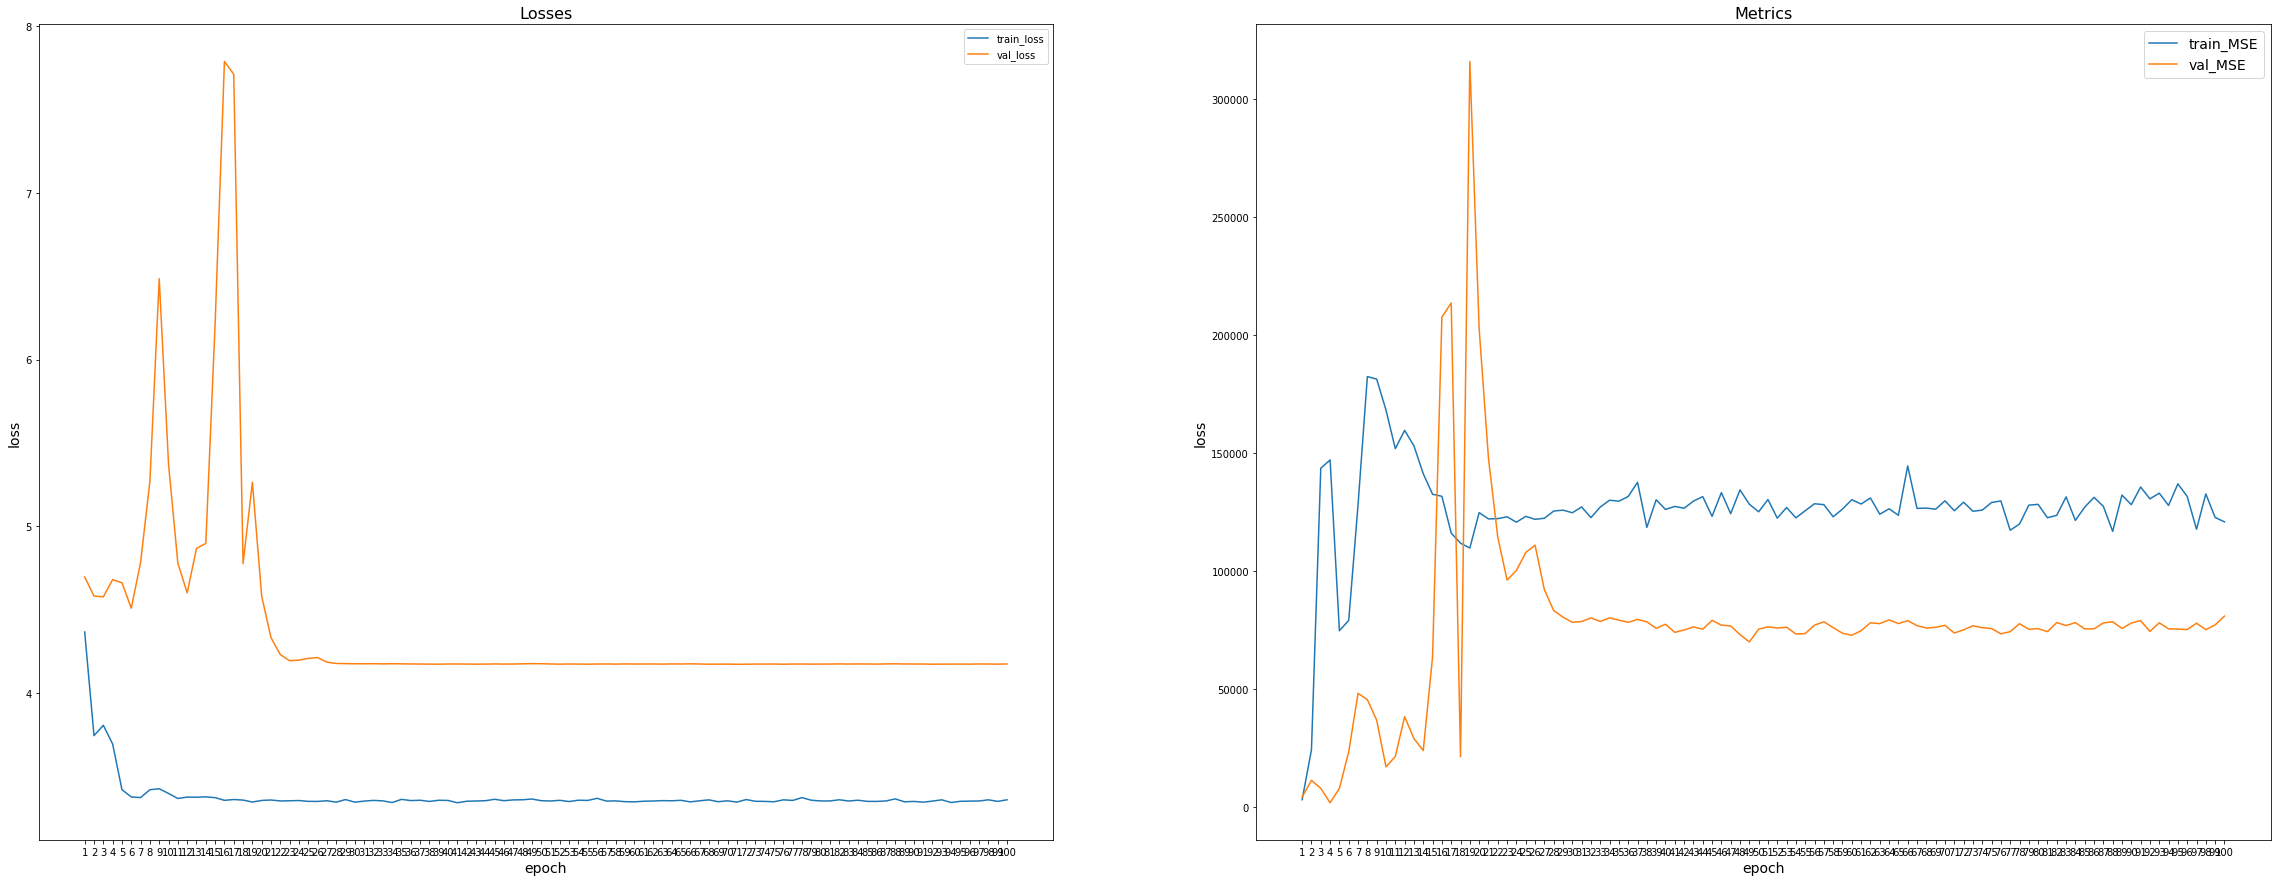

In [98]:
plot_history(history=history)

# 2) Output_size сеток с одномерным аутпутом (предполагаем независимость всех компонент силы)

Просто обучаю набор сеток на задачу регрессии, в качестве метрики для каждой сетки буду использовать MSE, а итоговая метрика - сумма MSE для каждой сетки

(Просто делаю массив из экземпляров сеток, optim-ов, loss-ов и потом циклом по ним делаю ровно тот же самый вызов history )

In [308]:
# Всем сеткам делаю абсолютно одинаковые гиперпараметры

models = [SingleNet(output_size=1) for _ in range(CFG.output_size)]

lr = 4e-3
betas=(0.9, 0.999)
weight_decay=0.1

optims = [optim.Adam(model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay) for model in models]

step_size = 5
gamma = 0.1

exp_schedulers = [lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) for optimizer in optims]

criterion = nn.MSELoss()

Самое главное при обучении этих моделей - то что у model[ i ] - таргет - это число force[ i ]

In [71]:
def train_models():
    '''
    
    Возвращает словарь из history для всех моделей: {1: history, 2: history, ...}

    '''

    histories = defaultdict(list)

    # Надо менять немного цикл обучения, чтобы таргетом для i сетки была i-ая компонента вектора силы

    # for i in range(CFG.output_size):
    #     histories[str(i)] = train(
    #         train_loader=train_loader,
    #         val_loader=val_loader,
    #         model=model,
    #         optimizer=optimizer,
    #         scheduler=exp_scheduler,
    #         criterion=nn.MSELoss(),
    #         epochs=10
    #     )

# 3) GPR модель 
    - (потом можно сюда навалить и сетку в качестве ядра и вообще deep GP юзать, плюс еще feature extractor в виде сверток юзать сначала, если очень большая матрица, но сначала надо обычный сделать)

## 3.1) Не стохастический подход

https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html - как обучать модели в gpytorch

https://docs.gpytorch.ai/en/v1.3.1/examples/04_Variational_and_Approximate_GPs/SVGP_Regression_CUDA.html - как обучать GP по мини батчам, когда данных слишком много

У авторов $C_{mn}$ - это матрица ковариации по всему датасету, а $d_{mn}$ - некоторое введенное расстояние между матрицами, чтобы мы могли использовать экспоненциальное ядро, короче нам надо какое-то ядро, которое две матрицы, а не два числа принимает

- Весьма убедительно считать расстояние между матрицами просто как l2 метрику между точками в NxN мерном пространстве

Короче надо GPR сделать, у которого точки - матрицы и прогнозируется векторная величина, то есть для матрицы $x_*$ из инпута мы должны получать: $\mu_* = E[f(x_*)]$ - трехмерное мат ожидание для предсказания и $S$

In [183]:
import gpytorch

- В предположении что компоненты силы независимы, можно использовать Batch Independent Multioutput GP, предсказывая [fx, fy, fz]

- Если предсказывать k проекций на все V_i, то компоненты уже зависимые и надо это учитывать и использовать другую модель: MultitaskGPModel

лосс делаем -mll: минус логарифм правдоподобия: $-log[p(output Y | test X)]$

In [184]:
# train_X = torch.stack([elem[0] for elem in train_data])
# train_Y = torch.stack([elem[1] for elem in train_data])

# val_X = torch.stack([elem[0] for elem in val_data])
# val_Y = torch.stack([elem[1] for elem in val_data])

fl = flattener()
train_X = fl(torch.stack([elem[0] for elem in train_data]))
train_Y = fl(torch.stack([elem[1] for elem in train_data]))

val_X = fl(torch.stack([elem[0] for elem in val_data]))
val_Y = fl(torch.stack([elem[1] for elem in val_data]))

**Про свертки и когда они ожидаемо будут и не будут работать:**

    - если мы используем обычный GP, то мы обязаны каждый шаг обучаться на всем train_X - так алгоритм работает, поэтому и сверточная сеть так же должна будет обучаться, по-сути с батч_сайз = дата_сайз, но оно так вычислительно неподъемно или просто не успеет за такое маленькое количество шагов обучиться

    - Поэтому стоит использовать алгоритм Stochastic Variational GP Regression, который подразумевает совместимость с torch.DataLoader, когда данных будет очень много, там используется стохастический алгоритм, позволяющий на батче обновлять параметры

In [111]:
class IndependentOutputsMultitaskGPModel(gpytorch.models.ExactGP):
    '''

    Class for multi output GPregression with independent components of output,
    formally we are training output_size GP models

    feature_extractor: torch network that consists only of convolutions (fully convolutional net)

    '''
    def __init__(self, train_x, train_y, likelihood, output_size=3, feature_extractor=None):
        super().__init__(train_x, train_y, likelihood)

        self.output_size = output_size

        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([output_size]))     # batch_shape позволяет нам для каждой модели отдельные параметры сделать
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([output_size])),
        )

        self.feature_extractor = flattener()
        if feature_extractor:
            self.feature_extractor = feature_extractor

        self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

    def forward(self, x):

        convoluted_n_flattened_x = self.feature_extractor(x)   # flattening
        convoluted_n_flattened_x = self.scale_to_bounds(convoluted_n_flattened_x)

        mean_x = self.mean_module(convoluted_n_flattened_x)
        covar_x = self.covar_module(convoluted_n_flattened_x)

        # print(f'Сайз выпрямленного:  {convoluted_n_flattened_x.size()} \n Сам выпрямленный: {convoluted_n_flattened_x}')

        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        )

In [112]:
class MinusLogLikelihoodLoss:
    def __init__(self, likelihood, model):
        self.mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    def __call__(self, model_output, true_target):
        '''

        model_output: what model(train_x) returns, mll uses likelihood by itself

        returns -mll(output, target)

        '''
        return -self.mll(model_output, true_target)

In [113]:
def GP_train(likelihood, model, optimizer, loss_obj, training_iterations: int, train_X, train_Y, print_step=1, scheduler=None):
    '''

    loss_obj should be an object of a class, which has __call__ method

    to have a clear perspective: on a stochastic network training I used around 2500 iterations

    returns history of MSE and loss

    '''
    model.train()
    likelihood.train()

    history = defaultdict(list)

    # scaler = amp.GradScaler()
    
    # Здесь нам не надо running_loss и running_MSE, потому что подаем сразу весь датасета в типе non-stochastic GP

    # Здесь реально обучаются параметры GPR, поскольку некоторая параметрическая часть у GPR все-таки присутствует
    for i in range(training_iterations):
        optimizer.zero_grad()

        output = model(train_X)

        loss = loss_obj(output, train_Y)
        loss.backward()

        predictions = likelihood(model(train_X))
        mean = predictions.mean
        lower, upper = predictions.confidence_region()

        # train_MSE = F.mse_loss(input=mean, target=train_Y, reduction='mean').item()   оно неправильно вычисляется, потому что в режиме train, мы mean получаем не для распределения у предсказаний, а тот который выучиили по трейну,
        # Короче говоря в режиме train мы не \mu* для объектов при предсказания получаем, а \mu, которое получаем из трейн датасета

        if i % print_step == 0:
            print(f'Iter: {i + 1}, train_MSE = TODO, train_loss = {loss}')

        optimizer.step()

        # history['MSE'].append(train_MSE)
        history['loss'].append(loss.item())

        if scheduler:
            # Так как здесь обучение не по мини-батчам, то каждую итерацию обновление
            scheduler.step()

    return history

Можно еще в процессе обучения параметров периодически смотреть на качество на валидационной выборке

In [114]:
def GP_eval(likelihood, model, optimizer, loss_obj, val_X, val_Y):
    '''
    
    One go dataset evaluation function

    '''
    model.eval()
    likelihood.eval()

    with torch.no_grad():
        output = model(val_X)
        loss = loss_obj(output, val_Y)

    predictions = likelihood(model(val_X))

    mean = predictions.mean
    print(mean)
    lower, upper = predictions.confidence_region()

    val_MSE = F.mse_loss(input=mean, target=val_Y, reduction='mean').item()

    print(f'val_MSE = {val_MSE}, val_loss = {loss.item()}')

    return mean, lower, upper

In [115]:
class LargeFeatureExtractor(torch.nn.Sequential):
    def __init__(self):
        super(LargeFeatureExtractor, self).__init__()
        self.add_module('linear1', torch.nn.Linear(CFG.K * CFG.K, 1000))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(1000, 500))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(500, 50))
        self.add_module('relu3', torch.nn.ReLU())
        self.add_module('linear4', torch.nn.Linear(50, 2))

In [123]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=CFG.output_size)

model = IndependentOutputsMultitaskGPModel(
    train_X,
    train_Y,
    likelihood,
    # feature_extractor=LargeFeatureExtractor()
    )

if likelihood.num_tasks != model.output_size:
    raise Exception('Different output dimensions for model and likelihood')

optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=0.1)

loss_obj = MinusLogLikelihoodLoss(likelihood=likelihood, model=model)

exp_scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

**Одно и то же значение для mean выводится в состоянии model.train(), потому что мы выбрали ConstMean и это типо и есть наше среднее, которое мы вычисляем по трейновому датасету**

In [126]:
train_history = GP_train(
    likelihood=likelihood,
    model=model,
    optimizer=optimizer,
    scheduler=None,
    loss_obj=loss_obj,

    training_iterations=35,

    train_X=train_X,
    train_Y=train_Y,

    print_step=5
)

Iter: 1, train_MSE = TODO, train_loss = 1.5248737335205078
Iter: 6, train_MSE = TODO, train_loss = 1.5250624418258667
Iter: 11, train_MSE = TODO, train_loss = 1.524994134902954
Iter: 16, train_MSE = TODO, train_loss = 1.5256409645080566
Iter: 21, train_MSE = TODO, train_loss = 1.5244710445404053
Iter: 26, train_MSE = TODO, train_loss = 1.524749994277954
Iter: 31, train_MSE = TODO, train_loss = 1.5247910022735596


одинаковые аутпуты в eval будут, если у нас очень резко сетка становится широкой из низкоразмерных данных, если мы используем feature_extractor, то есть та же проблема, что была с сетками просто

In [125]:
mean, lower, upper = GP_eval(
    likelihood=likelihood,
    model=model,
    optimizer=optimizer,
    loss_obj=loss_obj,
    val_X=val_X,
    val_Y=val_Y
)

tensor([[-6.1304e-02, -5.7415e-03, -1.8447e-02],
        [-1.6536e-03, -1.1975e-02,  8.2922e-04],
        [-1.3814e-02, -2.5125e-02,  1.2912e-02],
        ...,
        [-1.0563e-01, -6.8965e-02, -2.8466e-01],
        [ 7.9456e-02,  1.2491e-02,  8.8993e-02],
        [-2.8545e-03,  6.5455e-05, -6.2444e-03]], grad_fn=<ViewBackward0>)
val_MSE = 1.3439462184906006, val_loss = 1.5637437105178833


## 3.2) Stochastic Variational GP Regression (обучение GPR по мини батчам):

---

# Пока мои выводы / результаты: 

- Про сетки:
    - Поскольку в датасете огромное количество сил очень маленькие - модель не в состоянии научиться определять болшьие силы, надо какой-то кастомный лосс придумывать, учитывающий это

    - Пока по какой-то причине сетка просто выдает одинаковый аутпут на весь батч на большом количестве частиц (и со свертками и без, и при большом и при маленьком K)

    - Для 2 частиц с K = 2 на одной сетке получилось val_MSE = 0.75

    - Для 50 частиц с K = 25 вообще ничего не вышло, с K = 5 пока тоже

Поэтому я пока отложу идею с 3 сетками и попробую покрутить GPR

- Про GP:
    - на 50 частицах пока оно не учится...

    - на 2 частицах результат получше, чем у сетки, но что-то мне подсказывает, что MSE довольно плохая метрика в нашей ситуации

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler, scaler=None):
    '''

    Функция обучения по всем батчам 1 раз (1 эпоха)

    scaler: gradient scaler from torch.amp, попозже добавлю обучение с ним

    '''
    model.train()
    scaler = amp.GradScaler()

    running_loss = 0.0
    running_MSE = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        inputs = inputs.to(CFG.device)
        labels = labels.to(CFG.device)

        with amp.autocast(enabled=True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)

        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        running_MSE += F.mse_loss(input=outputs, target=labels, reduction='sum').item()
        processed_data += inputs.size(0)

    scheduler.step()
              
    train_loss = running_loss / processed_data
    train_MSE = running_MSE / processed_data
    
    return train_loss, train_MSE